In [2]:
# Importing libraries used for the analysis
import pandas as pd
import numpy as np

import plotly.offline as pyo
import plotly.graph_objs as go

# Using latest version of statsmodel 0.9.0 (otherwise get errors during SARIMAX fit)
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
googleSheetId = '1rOvejFB9yC9rSQdQbIzpC_VFKj9GcCDA6mOSFnZl_aQ'
worksheetName = 'peoplecounts'
URL = 'https://docs.google.com/spreadsheets/d/{0}/gviz/tq?tqx=out:csv&sheet={1}'.format(
    googleSheetId,
    worksheetName
)

historical_data = pd.read_csv(URL)

In [4]:
historical_data

,Date,Price,count
0,1/2/2019,54.91,439
1,1/3/2019,55.95,448
2,1/4/2019,57.06,456
3,1/7/2019,57.33,459
4,1/8/2019,58.72,470
...,...,...,...
589,4/15/2021,66.94,536
590,4/16/2021,66.77,534
591,4/19/2021,67.05,536
592,4/20/2021,66.57,533


In [5]:

# Set Date column to datetime for time series
historical_data['Date'] = pd.to_datetime(historical_data['Date'],infer_datetime_format=True)

# Data file is sorted from most recent date to the past so sorting by date to go the other way around
historical_data = historical_data.sort_values(by='Date', ascending=True)

# Resetting the index due to the sort_value change
historical_data = historical_data.reset_index(drop = True)

# Dropping all columns except for the Closing Price
historical_data = historical_data.drop(columns=['Price'])

# Setting the Date as the index
historical_data = historical_data.set_index('Date')

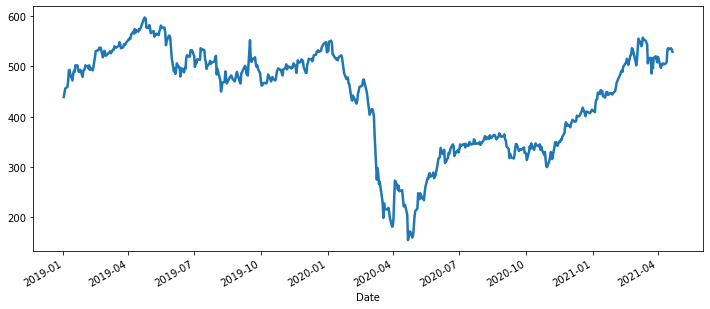

In [6]:
historical_data['count'].plot(lw=2.5, figsize=(12,5));

In [12]:
# Grabbing data from 2019-01-01
df = historical_data.loc['2019-01-01':]

In [13]:
##### evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
        # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 4)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
evaluate_models(df.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=6992.391
ARIMA(0, 0, 1) MSE=2010.636
ARIMA(0, 1, 0) MSE=76.720
ARIMA(0, 1, 1) MSE=77.835
ARIMA(0, 1, 2) MSE=77.944
ARIMA(0, 1, 3) MSE=78.145
ARIMA(0, 2, 0) MSE=169.062
ARIMA(0, 2, 1) MSE=77.321
ARIMA(0, 2, 2) MSE=78.829
ARIMA(0, 2, 3) MSE=79.017
ARIMA(1, 0, 0) MSE=76.443
ARIMA(1, 0, 1) MSE=77.613
ARIMA(1, 0, 2) MSE=77.718
ARIMA(1, 0, 3) MSE=77.902
ARIMA(1, 1, 0) MSE=77.845
ARIMA(1, 1, 1) MSE=77.390
ARIMA(1, 2, 0) MSE=118.041
ARIMA(1, 2, 1) MSE=78.789
ARIMA(1, 2, 2) MSE=79.309
ARIMA(1, 2, 3) MSE=79.986
ARIMA(2, 0, 0) MSE=77.633
ARIMA(2, 0, 1) MSE=77.209
ARIMA(2, 0, 2) MSE=78.155
ARIMA(2, 0, 3) MSE=79.911
ARIMA(2, 1, 0) MSE=77.924
ARIMA(2, 1, 3) MSE=78.915
ARIMA(2, 2, 0) MSE=103.032
ARIMA(2, 2, 1) MSE=79.004
ARIMA(2, 2, 2) MSE=80.134
ARIMA(3, 0, 0) MSE=77.699
ARIMA(3, 0, 1) MSE=78.101
ARIMA(3, 0, 2) MSE=78.864
ARIMA(3, 1, 0) MSE=78.106
ARIMA(3, 1, 1) MSE=77.758
ARIMA(3, 1, 2) MSE=78.921
ARIMA(3, 2, 0) MSE=101.432
ARIMA(3, 2, 1) MSE=79.357
ARIMA(3, 2, 2) MSE=80.377
ARIM

In [14]:
%%time

# Instantiating the model using SARIMAX, the optimal p, d, q values, and a seasonal order based on 365 days/year.
model = sm.tsa.statespace.SARIMAX(historical_data['count'],
                                order=(1, 0, 0),
                                seasonal_order=(1, 0, 0, 365),
                                enforce_stationarity=True,
                                enforce_invertibility=False)

# Fitting the model
SARIMAX_results = model.fit()

Wall time: 7min 48s


In [57]:
# Getting model's predictions of the in-sample data, rounding to two decimal places for price.
SARIMAX_predictions = round(SARIMAX_results.predict(), 0)

# Creating a dataframe of the date index and predictions
SARIMAX_preds = pd.DataFrame(list(zip(list(SARIMAX_predictions.index),list(SARIMAX_predictions))),
                             columns=['Date','Predictedcount']).set_index('Date')

# Merging the original dataframe with predictions for comparison
SARIMAX_predicted_df = pd.merge(historical_data[1:], SARIMAX_preds, left_index=True, right_index=True)

SARIMAX_predicted_df.head()

,count,Predictedcount
Date,,
2019-01-03,448,439.0
2019-01-04,456,448.0
2019-01-07,459,456.0
2019-01-08,470,459.0
2019-01-09,492,470.0


In [58]:
print("\tMean Squared Error:", mean_squared_error(SARIMAX_predicted_df['count'], 
                                                  SARIMAX_predicted_df['Predictedcount']))
print("\tRoot Mean Squared Error:", np.sqrt(mean_squared_error(SARIMAX_predicted_df['count'], 
                                                               SARIMAX_predicted_df['Predictedcount'])))

	Mean Squared Error: 120.95784148397976
	Root Mean Squared Error: 10.998083536870402


In [59]:
# Getting 6 months for forecasts
SARIMAX_forecast = round(SARIMAX_results.forecast(steps = 120), 0)


In [60]:
SARIMAX_forecast

594    530.0
595    532.0
596    531.0
597    531.0
598    531.0
       ...  
709    481.0
710    484.0
711    483.0
712    482.0
713    483.0
Length: 120, dtype: float64

In [61]:
# Creating an index from 10/29/2018 to six months out, frequency indicates business day which eliminates weekends and
# US holidays, then putting it all together into a SARIMAX_forecast dataframe
idx = pd.date_range('2021-04-20', '2021-10-01', freq='B')

SARIMAX_forecast = pd.DataFrame(list(zip(list(idx),list(SARIMAX_forecast))),
                             columns=['Date','ForecastCount']).set_index('Date')

SARIMAX_forecast.head()

,ForecastCount
Date,
2021-04-20,530.0
2021-04-21,532.0
2021-04-22,531.0
2021-04-23,531.0
2021-04-26,531.0


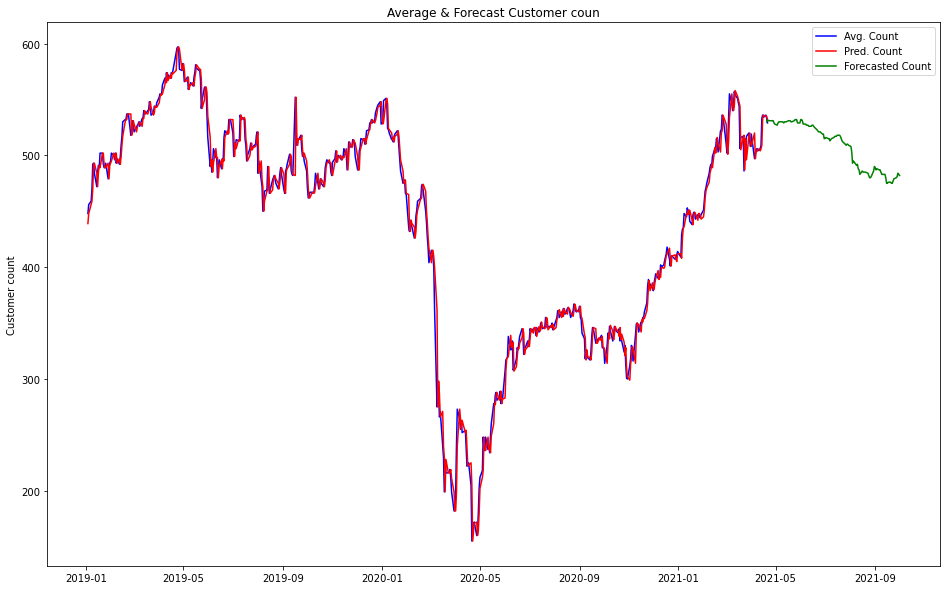

In [62]:
# Matplotlib Plot for Notebook

fig=plt.figure(figsize=[16,10])
fig.show()
ax=fig.add_subplot(111)

ax.plot(SARIMAX_predicted_df['count'],c='b',label='Avg. Count')
ax.plot(SARIMAX_predicted_df['Predictedcount'],c='r', label='Pred. Count')
ax.plot(SARIMAX_forecast['ForecastCount'],c='g', label='Forecasted Count')

plt.legend(loc='best')
plt.ylabel('Customer count')
plt.title('Average & Forecast Customer count')
plt.draw()

In [63]:
trace0 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['count'],
    mode = 'lines',
    name = 'Daily count'
)
trace1 = go.Scatter(
    x = SARIMAX_predicted_df.index,
    y = SARIMAX_predicted_df['Predictedcount'],
    mode = 'lines',
    name = 'Predicted count'
)
trace2 = go.Scatter(
    x = SARIMAX_forecast.index,
    y = SARIMAX_forecast['ForecastCount'],
    mode = 'lines',
    name = 'Forecast count'
)
data = [trace0, trace1, trace2]

layout = go.Layout(
    title = 'SARIMAX Model: Daily & 6-Month Forecast Person Count using Sinitizer usage',
    xaxis = dict(title = 'Date'),
    yaxis = dict(title = 'count)')
) 

fig = go.Figure(data = data, layout = layout)

pyo.plot(fig)

'temp-plot.html'